## Exploring Time Series With Transformers

In [38]:
# Configuration-driven universal setup cell (v2: supports project + shared src/)
import os
import sys
from pathlib import Path

# Fix OpenMP issues
os.environ['KMP_DUPLICATE_LIB_OK'] = 'TRUE'

# Centralized import config
# Format: {'relative_path_to_root_or_src': ['func1', 'func2']}
# Use None key for modules directly under the notebook's project root
IMPORT_CONFIG = {
    '../../src': ['plot_style'],                # shared across projects
    '.': ['models', 'data'],                    # project-local packages (optional)
}

def setup_imports():
    """Setup imports using relative paths and fallback strategies."""
    imported_modules = {}

    # Determine notebook directory as reference point
    notebook_dir = Path().resolve()  # CWD in notebook = its directory

    for rel_path, module_names in IMPORT_CONFIG.items():
        if rel_path == '.':
            search_path = notebook_dir
        else:
            search_path = (notebook_dir / rel_path).resolve()

        if not search_path.exists():
            print(f"Path not found: {search_path}")
            continue

        # Add to sys.path if not already present
        str_path = str(search_path)
        if str_path not in sys.path:
            sys.path.insert(0, str_path)

        # Import each module
        for mod_name in module_names:
            try:
                mod = __import__(mod_name)
                imported_modules[mod_name] = mod
                print(f"Imported '{mod_name}' from {search_path}")
            except ImportError as e:
                print(f"Failed to import '{mod_name}' from {search_path}: {e}")

    if not imported_modules:
        raise ImportError("No modules could be imported from configured paths.")

    return imported_modules

# Execute setup
try:
    imports = setup_imports()
    globals().update(imports)  # e.g., plot_style, models, data now available
    print("All imports ready")
except Exception as e:
    print(f"Import setup failed: {e}")
    raise

Imported 'plot_style' from /Users/banana/projects/ml/generative-models-journey/src
Imported 'models' from /Users/banana/projects/ml/generative-models-journey/projects/vqvae-transformer-ts
Imported 'data' from /Users/banana/projects/ml/generative-models-journey/projects/vqvae-transformer-ts
All imports ready


In [39]:
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import joblib

# Access shared style
from plot_style import colors

# Access local project code
from data.generate_synthetic import generate_dataset
from models.vqvae import VQVAETimeSeries
from models.transformer import TimeSeriesTransformer
from train_vqvae import train_vqvae


from sklearn.preprocessing import StandardScaler

import matplotlib.pyplot as plt

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

np.random.seed(42)

os.makedirs("artifacts/notebook/", exist_ok=True)

Goal: Learn a generative model for short multivariate time series using:

- A small VQ-VAE to compress sequences into discrete tokens.
- A minimal Transformer to model token sequences autoregressively.

### Data

We will be using short multivariate sequences $x \in \mathbb{R}^{T \times D}$, $T=16$, $D=3$. 
They will mimic key behaviors in financial data sets:
 - Regime shifts (calm vs volatile)
 - Trends and mean reversion
 - Noise with structure

Each sequence belongs to one of three types:

| Type | Description |  
|---|---|
| 1. Trending | Slow linear drift + low noise |  
|2. Mean-Reverting| Oscillates around zero, like OU process|
|3. Volatile Spike| Mostly flat, then sudden spike in middle|




In [40]:
print("1. Generating synthetic data...")
X, labels, scaler = generate_dataset(
        n_per_class=3000,
        T=16,
        D=3
    )
X = torch.tensor(X, dtype=torch.float32).to(device)

print("X dtype:", X.dtype)
print("X min:", X.min().item(), "X max:", X.max().item())
print("X mean:", X.mean().item(), "X std:", X.std().item())

# Save the scaler that was fitted on the training data
joblib.dump(scaler, "artifacts/notebook/vqvae_scaler.pkl")

1. Generating synthetic data...
X dtype: torch.float32
X min: -4.79072380065918 X max: 5.0
X mean: -0.0008904961287043989 X std: 0.9946180582046509


['artifacts/notebook/vqvae_scaler.pkl']

### Phase 1: "Tokenization" for Time Series

In time series tokenization means compressing a time window into a short sequence of discrete symbols ("codes"). We will use a VQ-VAE as our tokenizer.

It learns:

- An encoder that maps input to continuous latent
- A codebook that discretizes latent to nearest code
- A decoder that reconstructs from codes

```
Raw Time Series ──[Encoder]──→ z_e ──[Nearest Code]──→ c₁,c₂,... ──[Decoder]──→ Reconstructed
```
The sequence $\{c_n\}$ is the desired tokenized representation.

#### Model Architecture (Not accurate - changing during development)
```
Input (16,3)
   ↓ Flatten → 48
   ↓ Linear → 128
   ↓ ReLU
   ↓ Linear → 32 (→ reshape to L=2, K=16) ← z_e (continuous latent)
   ↓
[VQ Layer] → finds closest code in codebook (64 codes, dim=16)
   ↓ z_q (quantized, shape [B,4,16])
   ↓ Reshape → 32
   ↓ Linear → 128
   ↓ ReLU
   ↓ Linear → 48
   ↓ Reshape → (16,3)
Output (reconstruction)
```

### Training

Loss has two parts:

- Reconstruction loss: MSE between input and output
- VQ loss: commitment loss (stabilizes training)


In [41]:
n_codes = 64
code_dim = 16
n_tokens = 4

DEBUG=False

In [42]:
if(DEBUG): #see what's going on with the model
    model = VQVAETimeSeries(n_codes=n_codes, code_dim=code_dim, n_tokens=n_tokens)

    with torch.no_grad():
        z_e_sample = model.encode(X[:10])
        print("Latent std after norm:", z_e_sample.std().item())  # should be ~0.5-1.0
        model.vq_layer.codebook.weight.normal_(0, z_e_sample.std().item())

    model.eval()  # disable dropout if there is any

    with torch.no_grad():
        test_input = X[:2]  # 2 samples
        print("Input shape:", test_input.shape)
        print("Input range:", test_input.min().item(), test_input.max().item())
    
        recon, z_q, indices = model(test_input)
        print("Recon range:", recon.min().item(), recon.max().item())
        print("Recon shape:", recon.shape)
    
        mse = F.mse_loss(recon, test_input)
        print("Initial MSE:", mse.item())

        z_e = model.encode(test_input)
        print("z_e range:", z_e.min().item(), z_e.max().item())
        print("z_e std:", z_e.std().item())

In [43]:
n_epochs = 100
batch_size = 64
beta = 0.01  # commitment weight
learning_rate = 1e-3

In [44]:

model, history = train_vqvae(
    X,
    n_codes=n_codes,
    code_dim=code_dim,
    n_tokens=n_tokens,    
    n_epochs=n_epochs,
    batch_size=batch_size,
    learning_rate=learning_rate,
    beta=beta,
    device=device,
    checkpoint_interval=10,
    pth_path="artifacts/notebook/vqvae.pth"
    )


Starting training on cpu...
Epochs: 100, Batch size: 64
Epoch 0, Loss: 297.1561
Epoch 10, Loss: 260.4670
Epoch 20, Loss: 257.1442
Epoch 30, Loss: 255.6722
Epoch 40, Loss: 255.0745
Epoch 50, Loss: 254.3578
Epoch 60, Loss: 253.9908
Epoch 70, Loss: 254.0026
Epoch 80, Loss: 253.8416
Epoch 90, Loss: 253.6083
Training complete!
VQ-VAE model saved to artifacts/notebook/vqvae.pth


#### Model Diagnostics

In [45]:
# Diagnostic: Check z_e vs z_q
model.eval()  # set to evaluation mode (no dropout, etc.)
with torch.no_grad():  # disable gradient computation
    # Take a small batch (e.g., first 5 samples)
    batch = X[:5]  # shape: [5, 16, 3]
    
    # Get continuous latent from encoder
    z_e = model.encode(batch)  # shape: [5, n_tokens, code_dim]
    
    # Quantize it
    z_q, indices = model.vq_layer(z_e)  # z_q: [5, n_tokens, code_dim]
    
    # Print stats
    print("z_e std:", z_e.std().item())
    print("z_q std:", z_q.std().item())
    print("z_e mean:", z_e.mean().item())
    print("z_q mean:", z_q.mean().item())
    
    # Are they similar? (should be close if VQ works)
    diff = (z_e - z_q).abs().mean().item()
    print(f"Mean |z_e - z_q|: {diff:.4f}")

z_e std: 1.0015619993209839
z_q std: 0.7943262457847595
z_e mean: -9.685754420729609e-09
z_q mean: -0.01893884316086769
Mean |z_e - z_q|: 0.8843


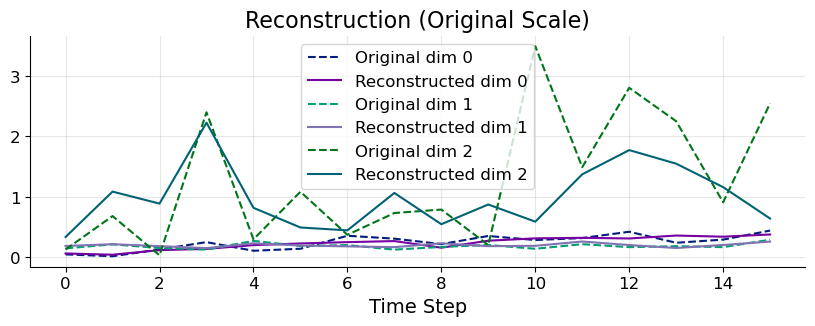

In [46]:
# Reconstruct
recon = model.decode(z_q)

# Inverse transform for meaningful plotting
orig_plot = scaler.inverse_transform(batch.reshape(-1, 48)).reshape(-1, 16, 3)
recon_plot = scaler.inverse_transform(recon.detach().numpy().reshape(-1, 48)).reshape(-1, 16, 3)

# Plot first sample
plt.figure(figsize=(10, 3))
for d in range(3):
    plt.plot(orig_plot[0, :, d], '--', label=f'Original dim {d}')
    plt.plot(recon_plot[0, :, d], '-', label=f'Reconstructed dim {d}')
plt.legend()
plt.title("Reconstruction (Original Scale)")
plt.xlabel("Time Step")
plt.grid(True, alpha=0.3)
plt.show()

Used 60 / 64 codes


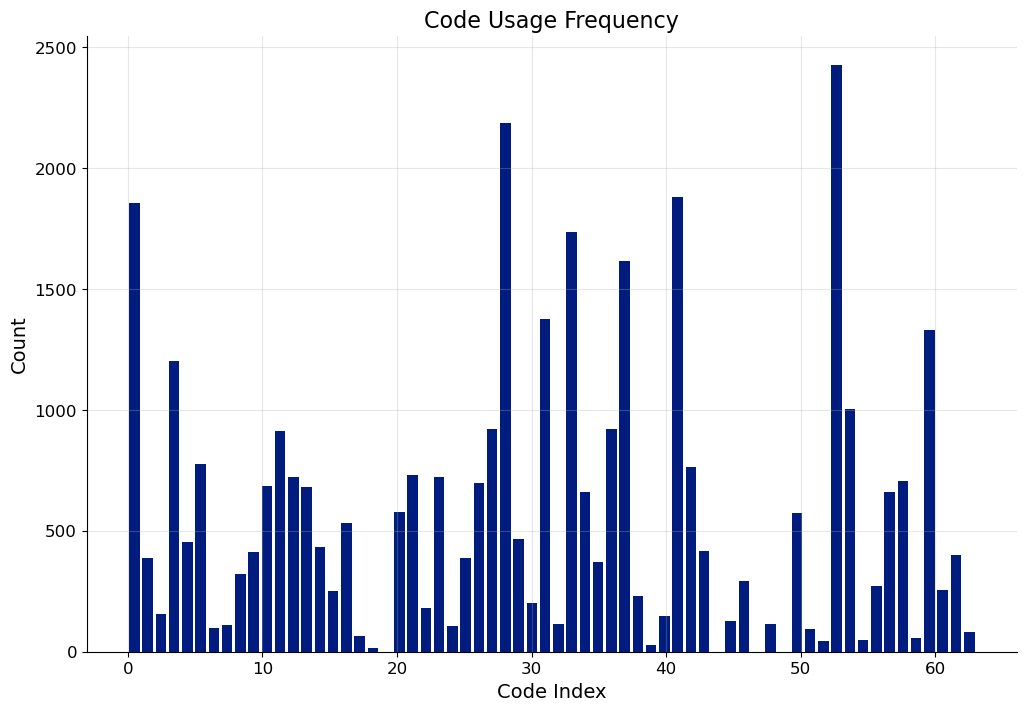

In [47]:
with torch.no_grad():
    _, _, indices = model(X)
    unique_codes = torch.unique(indices).numel()
    print(f"Used {unique_codes} / 64 codes")
    
    # Plot histogram of code usage
    plt.hist(indices.numpy().flatten(), bins=64, rwidth=0.8)
    plt.title("Code Usage Frequency")
    plt.xlabel("Code Index")
    plt.ylabel("Count")
    plt.show()

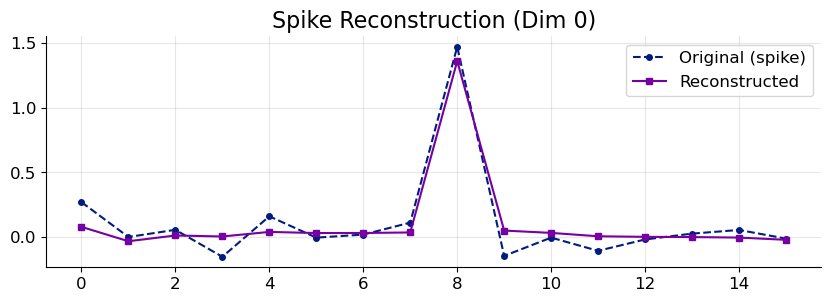

In [48]:
# Find a spike sample
spike_idx = np.where(labels == 2)[0][0]  # class 2 = spike
orig = X[spike_idx:spike_idx+1]
recon, _, _ = model(orig)

# Inverse transform
orig_plot = scaler.inverse_transform(orig.reshape(1, -1)).reshape(16, 3)
recon_plot = scaler.inverse_transform(recon.detach().numpy().reshape(1, -1)).reshape(16, 3)

plt.figure(figsize=(10, 3))
plt.plot(orig_plot[:, 0], 'o--', label='Original (spike)', markersize=4)
plt.plot(recon_plot[:, 0], 's-', label='Reconstructed', markersize=4)
plt.legend(); plt.title("Spike Reconstruction (Dim 0)")
plt.show()

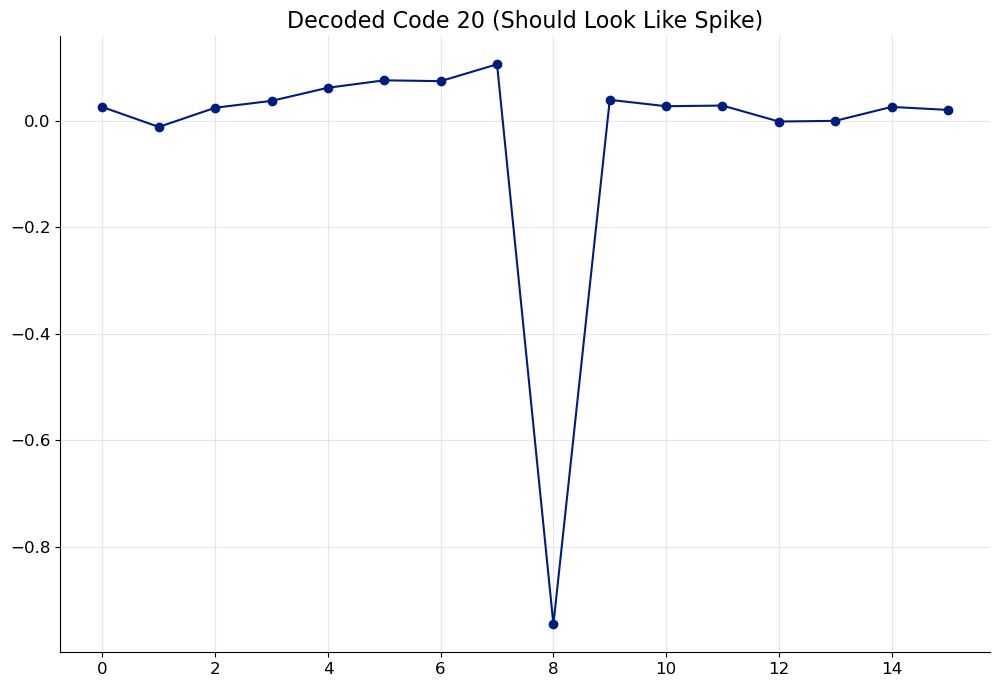

In [49]:
# Pick a code that appears in spike samples
spike_code = indices[labels == 2][0][0].item()  # first spike sample's code

# Create a batch of just this code
z_q = model.vq_layer.codebook.weight[spike_code].unsqueeze(0).unsqueeze(0)  # [1, 1, code_dim]
if n_tokens > 1:
    z_q = z_q.repeat(1, n_tokens, 1) 

recon = model.decode(z_q)

# Plot
recon_plot = scaler.inverse_transform(recon.detach().numpy().reshape(1, -1)).reshape(16, 3)
plt.plot(recon_plot[:, 0], 'o-')
plt.title(f"Decoded Code {spike_code} (Should Look Like Spike)")
plt.show()

### Transformer Prior

#### Training

First, prepare the data using our tokenizer.

In [50]:
# Load trained VQ-VAE
vqvae = VQVAETimeSeries(n_codes=64, code_dim=16, n_tokens=4)
vqvae.load_state_dict(torch.load("artifacts/notebook/vqvae.pth"))
vqvae.eval()

print("Extracting tokens...")
with torch.no_grad():
    _, _, indices = vqvae(X)
    token_dataset = indices.long().cpu()  # [N, n_tokens]

print("Token dataset shape:", token_dataset.shape)

Extracting tokens...
Token dataset shape: torch.Size([9000, 4])


#### The Training Loop

In [51]:
# Train the Transformer prior
from train_transformer import train_transformer

model, history = train_transformer(
    token_dataset,
    n_codes=64,
    n_tokens=4,
    d_model=32,
    n_heads=2,
    n_layers=2,
    n_epochs=50,
    batch_size=128,
    learning_rate=3e-4,
    device=device,
    checkpoint_interval=10,
    pth_path="artifacts/notebook/transformer.pth" 
)


Starting training on cpu...
Epochs: 50, Batch size: 128
Epoch 0, Loss: 292.4736
Epoch 10, Loss: 263.1841
Epoch 20, Loss: 259.8729
Epoch 30, Loss: 257.4033
Epoch 40, Loss: 255.9754
Training complete!
Time series transformer model saved to artifacts/notebook/transformer.pth


#### Sampling New Sequences

In [52]:
from utils.generation_pipeline import generate_vqvae_samples_from_model

num_samples = 5
vqvae_samples = generate_vqvae_samples_from_model(
    n_samples=num_samples, 
    device=device,
    model_path="artifacts/notebook/vqvae.pth",
    transformer_path="artifacts/notebook/transformer.pth",
    scaler_path="artifacts/notebook/vqvae_scaler.pkl",
    n_tokens=n_tokens,
)

#### Decode to Time Series

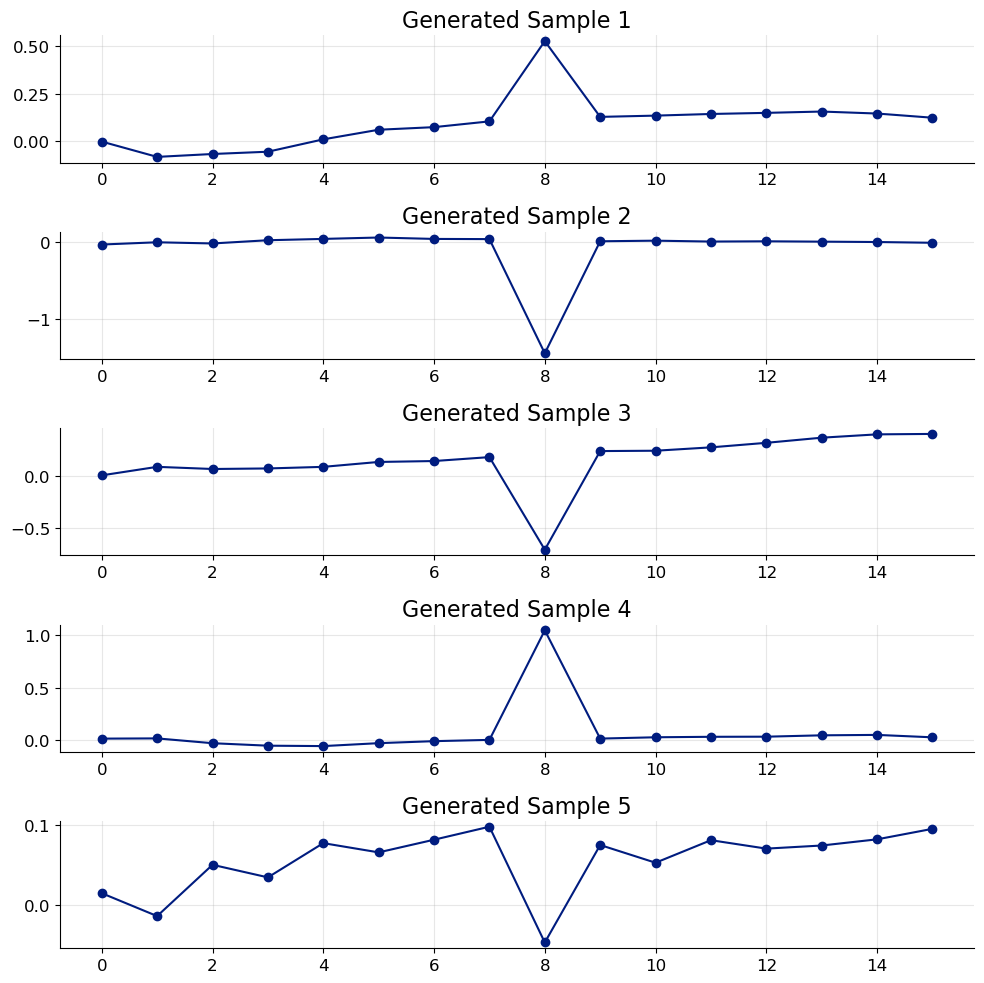

In [53]:
plt.figure(figsize=(10, 2 * num_samples))
for i in range(num_samples):
    plt.subplot(num_samples, 1, i + 1)
    plt.plot(vqvae_samples[i, :, 0], "o-")
    plt.title(f"Generated Sample {i+1}")
    plt.grid(True, alpha=0.3)

plt.tight_layout()